In [145]:
import pandas as pd 
import re
import os
import numpy as np
import shutil
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn-whitegrid')
from PIL import Image

from load_classes import fetch_classdict

###  Picking Useful Classes

In [147]:
'''
Given the amount of time that we have, constructing a proprietary network able to deal with
all of the included will take a lot of RnD.
'''
# classes of significance to this project: Classes of Interest (CoI)

class_dict = fetch_classdict()
print('all classes\n', class_dict)
coi_dict = fetch_classdict(mode='coi')
print('classes of interest\n', coi_dict)

all classes
 {'N': 'Normal', 'D': 'Diabetes', 'G': 'Glaucoma', 'C': 'Cataract', 'A': 'Age', 'H': 'Hypertension', 'M': 'Pathological', 'O': 'Other'}
classes of interest
 {'N': 'Normal', 'D': 'Diabetes', 'G': 'Glaucoma', 'C': 'Cataract', 'M': 'Pathological'}


### ToDo
- [x] Engineer the diagnosis/the fundus filenames which correspond to a certain disease.
- [x] Engineer the paths from the lists obtained.
- [x] Merge both Left and Right Fundii of dieseases into a single folder titled after that diagnosis 
- [ ] Using the paths, make distributions of Both Normal and the coi Diagnosis into repositories structured in convinience to the acceptable tensorflow format
- [ ] Distribute and balance the data according to the difference between Normal class and the actual class

### Engineering Left and Right Fundus Diagnosis from Keywords

In [7]:
print(coi_dict)
class_dict

{'N': 'Normal', 'D': 'Diabetes', 'G': 'Glaucoma', 'C': 'Cataract', 'M': 'Pathological'}


{'N': 'Normal',
 'D': 'Diabetes',
 'G': 'Glaucoma',
 'C': 'Cataract',
 'A': 'Age',
 'H': 'Hypertension',
 'M': 'Pathological',
 'O': 'Other'}

In [148]:
xdf = pd.read_excel('../../ODIR-data/ODIR-5K/ODIR-5K/data.xlsx')
metadf = pd.read_csv('../../ODIR-data/full_df.csv')

In [149]:
# df = xdf.copy(deep=True)
df = metadf.copy(deep=True)
df.head(2)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg


In [150]:
'normal' in 'abnormality'

True

In [151]:
coi_dict

{'N': 'Normal',
 'D': 'Diabetes',
 'G': 'Glaucoma',
 'C': 'Cataract',
 'M': 'Pathological'}

In [152]:
# test - pattern testing
if re.search(r'glaucoma','dry age-related macular degeneration，glaucoma'):
    print(True)

True


In [153]:
# Masking Functions
def has_pathological(text):
    if re.search(r'pathological',text):
        return 1
    else:
        return 0

def has_glaucoma(text):
    if re.search(r'glaucoma',text):
        return 1
    else:
        return 0
    
def has_diabetis(text):
    if re.search(r'[non]{3}?\s?proliferative retinopathy',text):
        return 1
    else:
        return 0
    
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

def has_normal(text):
    if "normal fundus" in text:
        return 1
    else:
        return 0
    
df["left_pathological"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_pathological(x))
df["right_pathological"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_pathological(x))

df["left_glaucoma"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
df["right_glaucoma"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))

df["left_diabetis"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_diabetis(x))
df["right_diabetis"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_diabetis(x))

df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

df["left_normal"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_normal(x))
df["right_normal"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_normal(x))

In [154]:
# Test -- passed
# normal_test = df[df['Right-Diagnostic Keywords'].str.contains('normal')][['Right-Diagnostic Keywords','Left-Diagnostic Keywords','labels','N','D','M','G','O','C','right_normal','left_normal']]
# normal_test[normal_test['Right-Diagnostic Keywords']!='normal fundus']

In [155]:
# # Test
# path_test = df[df['Right-Diagnostic Keywords'].str.contains('pathological')][['Right-Diagnostic Keywords','Left-Diagnostic Keywords','labels','N','D','M','G','O','C','right_pathological','left_pathological']]
# path_test

,Right-Diagnostic Keywords,Left-Diagnostic Keywords,labels,N,D,M,G,O,C,right_pathological,left_pathological
11,pathological myopia,pathological myopia,['M'],0,0,1,0,0,0,1,1
14,pathological myopia,normal fundus,['M'],0,0,1,0,0,0,1,0
16,pathological myopia,pathological myopia,['M'],0,0,1,0,0,0,1,1
37,pathological myopia,moderate non proliferative retinopathy,['M'],0,1,1,0,0,0,1,0
45,moderate non proliferative retinopathy，patholo...,normal fundus,['D'],0,1,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
4471,pathological myopia,refractive media opacity,['O'],0,0,1,0,1,0,1,0
4472,pathological myopia,pathological myopia,['M'],0,0,1,0,0,0,1,1
4473,pathological myopia,refractive media opacity,['O'],0,0,1,0,1,0,1,0
4476,moderate non proliferative retinopathy，patholo...,moderate non proliferative retinopathy，laser spot,['D'],0,1,1,0,1,0,1,0


In [157]:
df.head(2)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,left_pathological,right_pathological,left_glaucoma,right_glaucoma,left_diabetis,right_diabetis,left_cataract,right_cataract,left_normal,right_normal
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,1,1


In [158]:
# Collecting Images which are correlated to their corresponding diagnosis

left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values

left_normal = df.loc[(df.N ==1) & (df.left_normal == 1)]["Left-Fundus"].values
right_normal = df.loc[(df.N ==1) & (df.right_normal == 1)]["Right-Fundus"].values

left_diabetes = df.loc[(df.D ==1) & (df.left_diabetis == 1)]["Left-Fundus"].values
right_diabetes = df.loc[(df.D ==1) & (df.right_diabetis == 1)]["Right-Fundus"].values

left_glaucoma = df.loc[(df.G ==1) & (df.left_glaucoma == 1)]["Left-Fundus"].values
right_glaucoma = df.loc[(df.G ==1) & (df.right_glaucoma == 1)]["Right-Fundus"].values

left_pathological = df.loc[(df.M ==1) & (df.left_pathological == 1)]["Left-Fundus"].values
right_pathological = df.loc[(df.M ==1) & (df.right_pathological == 1)]["Right-Fundus"].values



# left_cataract = df.loc[df.left_cataract == 1]["Left-Fundus"].values
# right_cataract = df.loc[df.right_cataract == 1]["Right-Fundus"].values

# left_normal = df.loc[df.left_normal == 1]["Left-Fundus"].values
# right_normal = df.loc[df.right_normal == 1]["Right-Fundus"].values

# left_diabetes = df.loc[df.left_diabetis == 1]["Left-Fundus"].values
# right_diabetes = df.loc[df.right_diabetis == 1]["Right-Fundus"].values

# left_glaucoma = df.loc[df.left_glaucoma == 1]["Left-Fundus"].values
# right_glaucoma = df.loc[df.right_glaucoma == 1]["Right-Fundus"].values

# left_pathological = df.loc[df.left_pathological == 1]["Left-Fundus"].values
# right_pathological = df.loc[df.right_pathological == 1]["Right-Fundus"].values



In [159]:
order = ['Cataract', 'Diabetic Retinopathy', 'Glaucoma', 'Pathological Myopia', 'Normal']
left_samples = [left_cataract,left_diabetes,left_glaucoma, left_pathological, left_normal]
right_samples = [right_cataract, right_diabetes, right_glaucoma, right_pathological, right_normal]
left_dict = {}
right_dict = {}
# making dicts
for clsname, var in zip(order, left_samples):
    left_dict[clsname] = var
for clsname, var in zip(order, right_samples):
    right_dict[clsname] = var


In [169]:
with open('records.txt', 'w') as f:
    print('LEFT FUNDUS SAMPLES')
    f.write('LEFT FUNDUS SAMPLES\n')
    for key, value in zip(left_dict.keys(), left_dict.values()):
        print(f'{key}, samples: {len(value)}')
        f.write(f'{key}, samples: {len(value)}\n')
    print('*'*50)
    f.write('*'*50)
    f.write(' \n')

    print('RIGHT FUNDUS SAMPLES')
    f.write('RIGHT FUNDUS SAMPLES\n')
    for key, value in zip(right_dict.keys(), right_dict.values()):
        print(f'{key}, samples: {len(value)}')
        f.write(f'{key}, samples: {len(value)}\n')
    print('*'*50)
    f.write('*'*50)
    f.write(' \n')

    # Total Samples
    print('TOTAL SAMPLES - LEFT+RIGHT')
    f.write('TOTAL SAMPLES - LEFT+RIGHT\n')
    total_sum = 0
    for key, lvalue, _, rvalue in zip(left_dict.keys(), left_dict.values(),right_dict.keys(), right_dict.values()):
        total_sum += len(lvalue)+len(rvalue)
        print(f'{key}, samples: {len(lvalue)+len(rvalue)}')
        f.write(f'{key}, samples: {len(value)}\n')
    print('*'*50)
    f.write('*'*50)
    f.write(' \n')
    print(f'TOTAL SAMPLES OF ALL CLASSES - {total_sum}')
    f.write(f'TOTAL SAMPLES OF ALL CLASSES - {total_sum}\n')

LEFT FUNDUS SAMPLES
Cataract, samples: 304
Diabetic Retinopathy, samples: 1588
Glaucoma, samples: 332
Pathological Myopia, samples: 216
Normal, samples: 2100
**************************************************
RIGHT FUNDUS SAMPLES
Cataract, samples: 290
Diabetic Retinopathy, samples: 1658
Glaucoma, samples: 284
Pathological Myopia, samples: 241
Normal, samples: 2101
**************************************************
TOTAL SAMPLES - LEFT+RIGHT
Cataract, samples: 594
Diabetic Retinopathy, samples: 3246
Glaucoma, samples: 616
Pathological Myopia, samples: 457
Normal, samples: 4201
**************************************************
TOTAL SAMPLES OF ALL CLASSES - 9114


In [64]:
# saving progress
df.to_csv('engineered.csv')

In [170]:
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,left_pathological,right_pathological,left_glaucoma,right_glaucoma,left_diabetis,right_diabetis,left_cataract,right_cataract,left_normal,right_normal
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,...,0,0,0,0,0,0,1,0,0,1
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,...,0,0,0,0,0,0,0,0,1,1
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,1,1,0,0,0,0
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,...,0,0,0,0,1,0,0,0,0,0
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,...,0,0,0,0,1,1,0,0,0,0
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,...,0,0,0,0,1,0,0,0,0,1
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,...,0,0,0,0,1,1,0,0,0,0


In [171]:
'''
Description of the above process
* The above process, ignores the actual targets provided with the data because they are unreliable
in a contrary fashion, the data that we now have has the categories correctly correlated with 
their respective classes 
* This operation is done using the diagnostic keywords. each diagnosis has a unique set of words 
included in the keywords using which we extracted the diagnosis.
* According to the keywords, some patients seem to have multiple abnormalities in a single fundus which are
addressed using this operation of data extraction
'''

'\nDescription of the above process\n* The above process, ignores the actual targets provided with the data because they are unreliable\nin a contrary fashion, the data that we now have has the categories correctly correlated with \ntheir respective classes \n* This operation is done using the diagnostic keywords. each diagnosis has a unique set of words \nincluded in the keywords using which we extracted the diagnosis.\n* According to the keywords, some patients seem to have multiple abnormalities in a single fundus which are\naddressed using this operation of data extraction\n'

### Making distributions of the diseases

In [172]:
coi_dict

{'N': 'Normal',
 'D': 'Diabetes',
 'G': 'Glaucoma',
 'C': 'Cataract',
 'M': 'Pathological'}

In [173]:

# variable pairing 
class_pairs = {}
for classes in coi_dict.values():
    pair=[]
    pair.append('left_'+classes.lower())
    pair.append('right_'+classes.lower())
    class_pairs[classes] = pair
    
class_pairs

{'Normal': ['left_normal', 'right_normal'],
 'Diabetes': ['left_diabetes', 'right_diabetes'],
 'Glaucoma': ['left_glaucoma', 'right_glaucoma'],
 'Cataract': ['left_cataract', 'right_cataract'],
 'Pathological': ['left_pathological', 'right_pathological']}

In [174]:
root_file_path = '../../ODIR-data/ODIR-5K/ODIR-5K/Merged/' 
root_path = '../../ODIR-data/ODIR-5K/ODIR-5K/' 

aggregated = []

for key, value in zip(class_pairs.keys(),class_pairs.values()):

#     make directory
    class_path = os.path.join(root_path, key)
    os.makedirs(class_path)

    # copy files to the directory
    for orientation in value:
        for file in tqdm(eval(orientation),desc=orientation):
            aggregated.append(file)
            shutil.copy(os.path.join(root_file_path,file), class_path)
    
# print('Transitory')
# for key, value in zip(class_pairs.keys(),class_pairs.values()):
#     for orientation in value:
#         for file in tqdm(eval(orientation),desc=orientation):
#             try:
#                 shutil.move(os.path.join(root_file_path,file), os.path.join(root_path,'transitory'))
#             except:
#                 pass



right_pathological: 100%|██████████| 241/241 [00:00<00:00, 601.07it/s]


### Considerations
- [x] Check if there are any files still missing a correlation
     - if yes 
    - [ ] Funtionality to add the remaining files to the distribution
        - [ ] Make df containing only the files missing from both the aggregates
        - [ ] Apply the same feature extraction process
        - [ ] Use the same sorting pipeline to fill the distributions

### Structuring Repositories for TensorFlow Ops

**Example Structure**
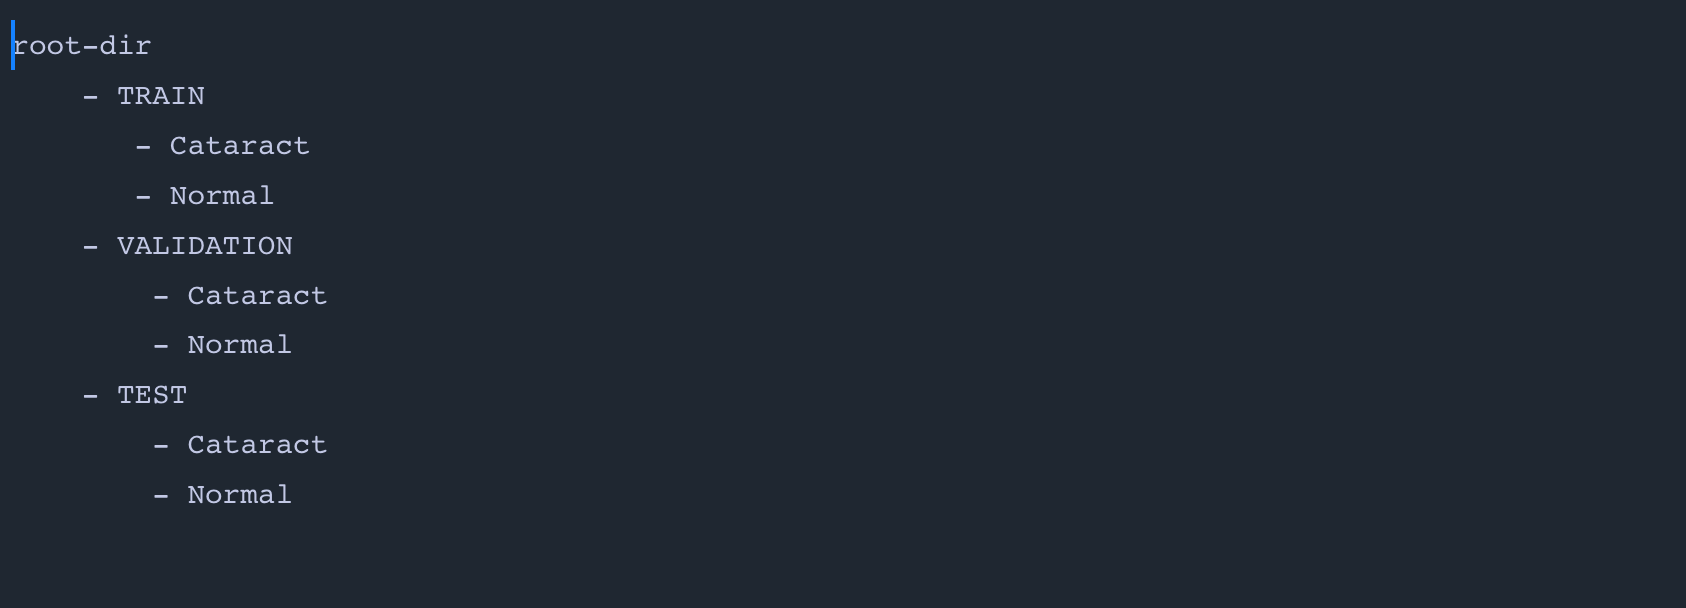

In [106]:
test = df[(df['Left-Diagnostic Keywords'].str.contains('normal fundus')) & df['Right-Diagnostic Keywords'].str.contains('normal fundus')]

In [108]:
len(list(test['Left-Fundus'])+ list(test['Right-Fundus']))

4204